In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.preprocessing import image as keras_image

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = keras_image.load_img(img_path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [3]:
import foolbox
import keras
import numpy as np
from keras.applications import inception_v3 as inc_net

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = inc_net.InceptionV3()

In [4]:
fmodel = foolbox.models.KerasModel(kmodel, bounds=(-1, 1))

In [5]:
image = transform_img_fn(["./strawberry.jpg"])[0]
label = 949

In [23]:
%%time
# apply attack on source image
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image, label)

CPU times: user 4.15 s, sys: 377 ms, total: 4.53 s
Wall time: 1.67 s


[('n07745940', 'strawberry', 0.99993932), ('n07836838', 'chocolate_sauce', 4.6697965e-05), ('n07613480', 'trifle', 5.4223847e-06), ('n07753275', 'pineapple', 2.6366729e-06), ('n07753592', 'banana', 1.0159853e-06)]


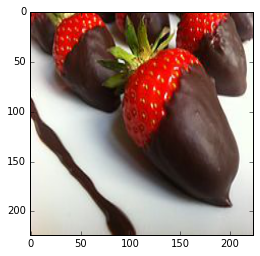

In [29]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(image / 2 + 0.5)
preds = kmodel.predict(np.expand_dims(image, axis=0))
for x in decode_predictions(preds):
    print(x)

[('n07836838', 'chocolate_sauce', 0.56614465), ('n07745940', 'strawberry', 0.4021042), ('n07614500', 'ice_cream', 0.014997269), ('n07613480', 'trifle', 0.011614716), ('n02948072', 'candle', 0.0011536067)]


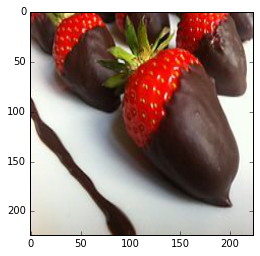

In [28]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(adversarial / 2 + 0.5)
preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
for x in decode_predictions(preds):
    print(x)

## Lime

In [30]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [32]:
%%time
explainer = lime_image.LimeImageExplainer()
explanation_adv = explainer.explain_instance(adversarial, kmodel.predict, top_labels=5, hide_color=0, num_samples=200)

CPU times: user 2min 7s, sys: 11.2 s, total: 2min 18s
Wall time: 40.1 s


In [40]:
%%time
explainer2 = lime_image.LimeImageExplainer()
explanation_img = explainer2.explain_instance(image, kmodel.predict, top_labels=5, hide_color=0, num_samples=200)

CPU times: user 2min 7s, sys: 11.2 s, total: 2min 18s
Wall time: 40.5 s


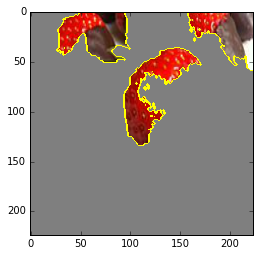

In [54]:
label_img = 949
temp, mask = explanation_adv.get_image_and_mask(label_img, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

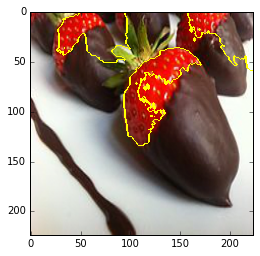

In [56]:
label_img = 949
temp, mask = explanation_adv.get_image_and_mask(label_img, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

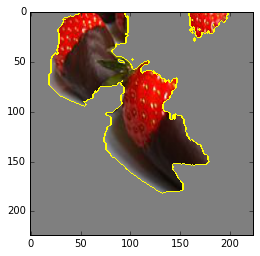

In [55]:
temp, mask = explanation_img.get_image_and_mask(label_img, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

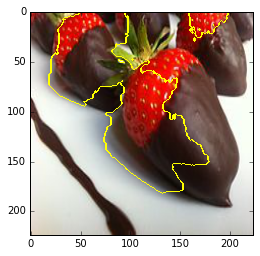

In [57]:
temp, mask = explanation_img.get_image_and_mask(label_img, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))